(array([[0.58094894, 0.25474515],
       [0.4721053 , 0.55324155],
       [0.86299645, 0.19012235],
       ...,
       [0.12115415, 2.37839845],
       [0.72335908, 2.74861775],
       [0.97429047, 2.42525076]]), array([[-0.00067057],
       [ 0.02076453],
       [-0.005634  ],
       ...,
       [ 0.1987031 ],
       [ 0.19997212],
       [ 0.18092349]], dtype=float32))


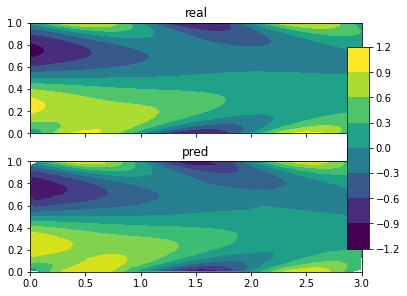

In [1]:
import os
import sys
sys.path.append('..\\..\\')
import pickle
file = '..\\..\\para_result\\heatud\\test_record.pkl'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from user_fun.io import read_comsol
from user_fun.io.read_comsol import process_comsol_time_table

def plot_result(plot_input, plot_output):

    tb = read_comsol.comsol_read('time_heat.csv', skiprows=8)
    tb = process_comsol_time_table(tb, space_dimension=1)
    x = tb['x'].to_numpy()
    t = tb['t'].to_numpy()
    u = tb['u (K)'].to_numpy()


    # Create color normalization
    vmin = np.min(u)
    vmax = np.max(u)
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=vmin, vmax=vmax)

    # Create plots with vertical arrangement
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True,constrained_layout=True)

    # Set axis limits
    for ax in axs:
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')

    # Create triangulation object
    triang2 = tri.Triangulation(plot_input[:,1], plot_input[:,0])
    triang1 = tri.Triangulation(t,x)

    # Plot tricontour 1
    cn1 = axs[0].tricontourf(triang1, u, cmap='viridis', norm=norm)
    axs[0].set_title('real')

    # Plot tricontour 2
    cn2 = axs[1].tricontourf(triang2, plot_output[:, 0], cmap='viridis', norm=norm)
    axs[1].set_title('pred')

    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(cn1, cax=cbar_ax, orientation='vertical')


with open(file, 'rb') as file:
    loaded_test_record = pickle.load(file)

import matplotlib.pyplot as plt
for i in range(len(loaded_test_record)):
    plot_input = loaded_test_record[i][0]
    plot_output = loaded_test_record[i][1]

plot_result(plot_input, plot_output)
c = loaded_test_record[0]
print(c)


In [2]:
import numpy as np
from scipy.interpolate import griddata

tb = read_comsol.comsol_read('time_heat.csv', skiprows=8)
tb = process_comsol_time_table(tb, space_dimension=1)
x = tb['x'].to_numpy()
t = tb['t'].to_numpy()
u = tb['u (K)'].to_numpy()


x_range = np.linspace(min(x.min(), plot_input[:,0].min()), max(x.max(), plot_input[:,0].max()), 100)
y_range = np.linspace(min(t.min(), plot_input[:,1].min()), max(t.max(), plot_input[:,1].max()), 100)
X, Y = np.meshgrid(x_range, y_range)

u_real_interp = griddata((x, t), u, (X, Y), method='cubic')

u_pred_interp = griddata((plot_input[:,0],plot_input[:,1]), plot_output[:, 0], (X, Y), method='cubic')

# 在 u_pred_interp 中找到 NaN 值的位置
nan_mask = np.isnan(u_pred_interp)

# 使用 ~nan_mask 筛选出没有 NaN 值的元素
u_real_interp_no_nan = u_real_interp[~nan_mask]
u_pred_interp_no_nan = u_pred_interp[~nan_mask]

# 计算相对误差
relative_error = np.abs((u_real_interp_no_nan - u_pred_interp_no_nan))


mean_relative_error = np.nanmean(relative_error)
print(mean_relative_error)
max_relative_error = np.nanmax(relative_error)





0.009994179332721634


In [3]:
from user_fun.io import read_comsol
import numpy as np
from scipy.interpolate import griddata

def calculate_error(plot_input, plot_output):
    tb = read_comsol.comsol_read('time_heat.csv', skiprows=8)
    tb = process_comsol_time_table(tb, space_dimension=1)
    x = tb['x'].to_numpy()
    t = tb['t'].to_numpy()
    u = tb['u (K)'].to_numpy()

    x_range = np.linspace(min(x.min(), plot_input[:, 0].min()), max(x.max(), plot_input[:, 0].max()), 100)
    y_range = np.linspace(min(t.min(), plot_input[:, 1].min()), max(t.max(), plot_input[:, 1].max()), 100)
    X, Y = np.meshgrid(x_range, y_range)

    u_real_interp = griddata((x, t), u, (X, Y), method='cubic')
    u_pred_interp = griddata((plot_input[:, 0], plot_input[:, 1]), plot_output[:, 0], (X, Y), method='cubic')

    nan_mask = np.isnan(u_pred_interp)
    u_real_interp_no_nan = u_real_interp[~nan_mask]
    u_pred_interp_no_nan = u_pred_interp[~nan_mask]

    relative_error = np.abs((u_real_interp_no_nan - u_pred_interp_no_nan))

    mean_relative_error = np.nanmean(relative_error)
    max_relative_error = np.nanmax(relative_error)

    return mean_relative_error, max_relative_error

mean_error, max_error = calculate_error(plot_input, plot_output)

print("Mean relative error:", mean_error)
print("Max relative error:", max_error)

Mean relative error: 0.009994179332721634
Max relative error: 0.0815150808054713
